**Project Network Analysis**

Step 2.1: Unipartite Graph (Odd Ball Analysis)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Required packages
!pip install fuzzywuzzy  &> /dev/null

In [ ]:
from networkx.algorithms.isolate import isolates
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import os
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import numpy as np
import matplotlib as mlt

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
path = '/content/drive/MyDrive/3. IU Courses/Courses/5. Network Analysis/Project/Final/data'
output_path = '/content/drive/MyDrive/3. IU Courses/Courses/5. Network Analysis/Project/Final/output'

# Reading Procurement Data
wb_data = pd.read_excel(os.path.join(output_path, "WB_table.xlsx"))
sanctioned_data = pd.read_excel(os.path.join(path, "Sanctioned_List.xlsx"))

In [ ]:
wb_data.head()

,Fiscal Year,Borrower Country,Supplier,Total Contract Amount (USD)
0,2022,Serbia,ASSECO SEE D.O.O.,3333598
1,2022,Ethiopia,"EPTISA SERVICIOS DE INGENIERIA, S.L. IN ASSOCI...",1851919
2,2022,China,"SHENZHEN CITY DONGSHEN ENGINEERING CO., LTD",14986361
3,2022,Turkey,KOLTEK MUSAVIRLIK A.S.,777600
4,2022,Chad,UNICEF,19326986


**Converting the DataFrame to Network**

In [ ]:
# Select year for analysis
year = 2021
# Grouping repeated transactions between country and suppliers
wb_data_filter = wb_data[wb_data['Fiscal Year'] == year]
wb_data_group = wb_data_filter.groupby(['Fiscal Year','Borrower Country','Supplier'])['Total Contract Amount (USD)'].sum()
wb_data_group = wb_data_group.reset_index()

In [ ]:
# Setting up the network 
G = nx.Graph()
G.add_nodes_from(wb_data_group['Borrower Country'], bipartite='Country') 
G.add_nodes_from(wb_data_group['Supplier'], bipartite='Supplier') 
G.add_weighted_edges_from(zip(wb_data_group['Borrower Country'], wb_data_group['Supplier'], wb_data_group['Total Contract Amount (USD)']), weight = 'contract_amt')

In [ ]:
print(nx.info(G))
G.to_undirected()

Graph with 1677 nodes and 1596 edges


In [ ]:
# Conversion to projection network with sum of contract amount as weights
def my_weight(G, u, v, weight='contract_amt'):
    w = 0
    for nbr in set(G[u]) & set(G[v]):         
         w += G.edges[u,nbr].get(weight, 1) + G.edges[v, nbr].get(weight,1)        
    return w

supplier_nodes = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 'Supplier'] 
Supplier_graph = bipartite.generic_weighted_projected_graph(G, nodes=supplier_nodes, weight_function=my_weight)
print(nx.info(Supplier_graph))

Graph with 1565 nodes and 40332 edges


**Example from year 2021: Validating the results**
    : The weights should be sum total of individual weights with higher node

    1. Turkey >> Indivial Consultant (weight = 10446)
    2. Turkey >> TURK PRYSMIAN KABLO VE SISTEMLERI A.S (weight = 168110137.0)
        
    168110137.0 + 10446 = 168120583
    
    In Projection Network
    TURK PRYSMIAN KABLO VE SISTEMLERI A.S >> Indivial Consultant (weight = 168120583.0) 

In [ ]:
wb_data_group[wb_data_group["Borrower Country"] =="Turkey"].groupby(['Borrower Country', 'Supplier'])['Total Contract Amount (USD)'].sum()

Borrower Country  Supplier                                       
Turkey            DOLSAR MUHENDISLIK                                   9558000
                  ERNST AND YOUNG TURKEY                              12305935
                  HIDRO DIZAYN                                         6070306
                  LS CABLE SYSTEM LTD                                 56210204
                  PWC DANISMANLIK HIZMETLERI A.S.                      6949975
                  SAFEGE                                              11958690
                  TEMELSU ULUSLARARASI MUSAVIRLIK HIZMETLERI A.S.      6307856
                  TURK PRYSMIAN KABLO VE SISTEMLERI A.S              168110137
Name: Total Contract Amount (USD), dtype: int64

In [ ]:
H = nx.subgraph(Supplier_graph, ['TURK PRYSMIAN KABLO VE SISTEMLERI A.S','INDIVIDUAL CONSULTANT'] )
print(H.edges(data=True))

[]


In [ ]:
print(f'Is connected: {nx.is_connected(Supplier_graph)}')
Supplier_graph.remove_nodes_from(list(nx.isolates(Supplier_graph)))

Is connected: False


In [ ]:
nx.write_gml(Supplier_graph, os.path.join(output_path, (str(year) + "uni_graph.gml")))

In [ ]:
'''
Data load and pre process for oddball
@author:
Tao Yu (gloooryyt@gmail.com)
'''

import numpy as np
import networkx as nx

#load data, a weighted undirected graph
def load_data(path):
    data = np.loadtxt(path).astype('int32')
    G = nx.Graph()
    for ite in data:
        G.add_edge(ite[0], ite[1], weight=ite[2])
    return G


def get_feature(G):
    #feature dictionary which format is {node i's id:Ni, Ei, Wi, λw,i}
    featureDict = {}
    nodelist = list(G.nodes)
    for ite in nodelist:
        featureDict[ite] = []
        #the number of node i's neighbor
        Ni = G.degree(ite)
        featureDict[ite].append(Ni)
        #the set of node i's neighbor
        iNeighbor = list(G.neighbors(ite))
        #the number of edges in egonet i
        Ei = 0
        #sum of weights in egonet i
        Wi = 0
        #the principal eigenvalue(the maximum eigenvalue with abs) of egonet i's weighted adjacency matrix
        Lambda_w_i = 0
        Ei += Ni
        egonet = nx.Graph()
        for nei in iNeighbor:
            Wi += G[nei][ite]['weight']
            egonet.add_edge(ite, nei, weight=G[nei][ite]['weight'])
        iNeighborLen = len(iNeighbor)
        for it1 in range(iNeighborLen):
            for it2 in range(it1+1, iNeighborLen):
                #if it1 in it2's neighbor list
                if iNeighbor[it1] in list(G.neighbors(iNeighbor[it2])):
                    Ei += 1
                    Wi += G[iNeighbor[it1]][iNeighbor[it2]]['weight']
                    egonet.add_edge(iNeighbor[it1], iNeighbor[it2], weight=G[iNeighbor[it1]][iNeighbor[it2]]['weight'])
        egonet_adjacency_matrix = nx.adjacency_matrix(egonet).todense()
        eigenvalue, eigenvector = np.linalg.eig(egonet_adjacency_matrix)
        eigenvalue.sort()
        Lambda_w_i = max(abs(eigenvalue[0]), abs(eigenvalue[-1]))
        featureDict[ite].append(Ei)
        featureDict[ite].append(Wi)
        featureDict[ite].append(Lambda_w_i)
    return featureDict


In [ ]:
'''
Python3 implementation of oddball
@author:
Tao Yu (gloooryyt@gmail.com)
'''

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor

# feature dictionary which format is {node i's id:Ni, Ei, Wi, λw,i}

def star_or_clique(featureDict):
    N = []
    E = []
    for key in featureDict.keys():
        N.append(featureDict[key][0])
        E.append(featureDict[key][1])
    #E=CN^α => log on both sides => logE=logC+αlogN
    #regard as y=b+wx to do linear regression
    #here the base of log is 2
    y_train = np.log2(E)
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(E), 1)
    x_train = np.log2(N)
    x_train = np.array(x_train)
    x_train = x_train.reshape(len(N), 1)
    model = LinearRegression()
    model.fit(x_train, y_train)
    w = model.coef_[0][0]
    b = model.intercept_[0]
    C = 2**b
    alpha = w
    outlineScoreDict = {}
    for key in featureDict.keys():
        yi = featureDict[key][1]
        xi = featureDict[key][0]
        outlineScore = (max(yi, C*(xi**alpha))/min(yi, C*(xi**alpha)))*np.log(abs(yi-C*(xi**alpha))+1)
        outlineScoreDict[key] = outlineScore
    return outlineScoreDict


def heavy_vicinity(featureDict):
    W = []
    E = []
    for key in featureDict.keys():
        W.append(featureDict[key][2])
        E.append(featureDict[key][1])
    #W=CE^β => log on both sides => logW=logC+βlogE
    #regard as y=b+wx to do linear regression
    #here the base of log is 2
    y_train = np.log2(W)
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(W), 1)
    x_train = np.log2(E)
    x_train = np.array(x_train)
    x_train = x_train.reshape(len(E), 1)
    model = LinearRegression()
    model.fit(x_train, y_train)
    w = model.coef_[0][0]
    b = model.intercept_[0]
    C = 2**b
    beta = w
    outlineScoreDict = {}
    for key in featureDict.keys():
        yi = featureDict[key][2]
        xi = featureDict[key][1]
        outlineScore = (max(yi, C*(xi**beta))/min(yi, C*(xi**beta)))*np.log(abs(yi-C*(xi**beta))+1)
        outlineScoreDict[key] = outlineScore
    return outlineScoreDict


def dominant_edge(featureDict):
    Lambda_w_i = []
    W = []
    for key in featureDict.keys():
        Lambda_w_i.append(featureDict[key][3])
        W.append(featureDict[key][2])
    #λ=CW^γ => log on both sides => logλ=logC+γlogW
    #regard as y=b+wx to do linear regression
    #here the base of log is 2
    y_train = np.log2(Lambda_w_i)
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(Lambda_w_i), 1)
    x_train = np.log2(W)
    x_train = np.array(x_train)
    x_train = x_train.reshape(len(W), 1)
    model = LinearRegression()
    model.fit(x_train, y_train)
    w = model.coef_[0][0]
    b = model.intercept_[0]
    C = 2 ** b
    beta = w
    outlineScoreDict = {}
    for key in featureDict.keys():
        yi = featureDict[key][3]
        xi = featureDict[key][2]
        outlineScore = (max(yi, C * (xi ** beta)) / min(yi, C * (xi ** beta))) * np.log(abs(yi - C * (xi ** beta)) + 1)
        outlineScoreDict[key] = outlineScore
    return outlineScoreDict


def star_or_clique_withLOF(featureDict):
    N = []
    E = []
    for key in featureDict.keys():
        N.append(featureDict[key][0])
        E.append(featureDict[key][1])
    #E=CN^α => log on both sides => logE=logC+αlogN
    #regard as y=b+wx to do linear regression
    #here the base of log is 2
    y_train = np.log2(E)
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(E), 1)
    x_train = np.log2(N)
    x_train = np.array(x_train)
    x_train = x_train.reshape(len(N), 1)    #the order in x_train and y_train is the same as which in featureDict.keys() now

    #prepare data for LOF
    xAndyForLOF = []
    for index in range(len(N)):
        tempArray = np.array([x_train[index][0], y_train[index][0]])
        xAndyForLOF.append(tempArray)
    xAndyForLOF = np.array(xAndyForLOF)

    model = LinearRegression()
    model.fit(x_train, y_train)
    w = model.coef_[0][0]
    b = model.intercept_[0]
    C = 2**b
    alpha = w
    print('alpha={}'.format(alpha))

    #LOF algorithm
    clf = LocalOutlierFactor(n_neighbors=20)
    clf.fit(xAndyForLOF)
    LOFScoreArray = -clf.negative_outlier_factor_

    outScoreDict = {}
    count = 0   #Used to take LOFScore in sequence from LOFScoreArray

    #get the maximum outLine
    maxOutLine = 0
    for key in featureDict.keys():
        yi = featureDict[key][1]
        xi = featureDict[key][0]
        outlineScore = (max(yi, C*(xi**alpha))/min(yi, C*(xi**alpha)))*np.log(abs(yi-C*(xi**alpha))+1)
        if outlineScore > maxOutLine:
            maxOutLine = outlineScore

    print('maxOutLine={}'.format(maxOutLine))

    #get the maximum LOFScore
    maxLOFScore = 0
    for ite in range(len(N)):
        if LOFScoreArray[ite] > maxLOFScore:
            maxLOFScore = LOFScoreArray[ite]

    print('maxLOFScore={}'.format(maxLOFScore))

    for key in featureDict.keys():
        yi = featureDict[key][1]
        xi = featureDict[key][0]
        outlineScore = (max(yi, C*(xi**alpha))/min(yi, C*(xi**alpha)))*np.log(abs(yi-C*(xi**alpha))+1)
        LOFScore = LOFScoreArray[count]
        count += 1
        outScore = outlineScore/maxOutLine + LOFScore/maxLOFScore
        outScoreDict[key] = outScore
    return outScoreDict


def heavy_vicinity_withLOF(featureDict):
    W = []
    E = []
    for key in featureDict.keys():
        W.append(featureDict[key][2])
        E.append(featureDict[key][1])
    #W=CE^β => log on both sides => logW=logC+βlogE
    #regard as y=b+wx to do linear regression
    #here the base of log is 2
    y_train = np.log2(W)
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(W), 1)
    x_train = np.log2(E)
    x_train = np.array(x_train)
    x_train = x_train.reshape(len(E), 1)    #the order in x_train and y_train is the same as which in featureDict.keys() now

    #prepare data for LOF
    xAndyForLOF = []
    for index in range(len(W)):
        tempArray = np.array([x_train[index][0], y_train[index][0]])
        xAndyForLOF.append(tempArray)
    xAndyForLOF = np.array(xAndyForLOF)

    model = LinearRegression()
    model.fit(x_train, y_train)
    w = model.coef_[0][0]
    b = model.intercept_[0]
    C = 2**b
    beta = w
    print('beta={}'.format(beta))

    #LOF algorithm
    clf = LocalOutlierFactor(n_neighbors=20)
    clf.fit(xAndyForLOF)
    LOFScoreArray = -clf.negative_outlier_factor_

    outScoreDict = {}
    count = 0   #Used to take LOFScore in sequence from LOFScoreArray

    #get the maximum outLine
    maxOutLine = 0
    for key in featureDict.keys():
        yi = featureDict[key][2]
        xi = featureDict[key][1]
        outlineScore = (max(yi, C*(xi**beta))/min(yi, C*(xi**beta)))*np.log(abs(yi-C*(xi**beta))+1)
        if outlineScore > maxOutLine:
            maxOutLine = outlineScore

    print('maxOutLine={}'.format(maxOutLine))

    #get the maximum LOFScore
    maxLOFScore = 0
    for ite in range(len(W)):
        if LOFScoreArray[ite] > maxLOFScore:
            maxLOFScore = LOFScoreArray[ite]

    print('maxLOFScore={}'.format(maxLOFScore))

    for key in featureDict.keys():
        yi = featureDict[key][2]
        xi = featureDict[key][1]
        outlineScore = (max(yi, C*(xi**beta))/min(yi, C*(xi**beta)))*np.log(abs(yi-C*(xi**beta))+1)
        LOFScore = LOFScoreArray[count]
        count += 1
        outScore = outlineScore/maxOutLine + LOFScore/maxLOFScore
        outScoreDict[key] = outScore
    return outScoreDict

def dominant_edge_withLOF(featureDict):
    Lambda_w_i = []
    W = []
    for key in featureDict.keys():
        Lambda_w_i.append(featureDict[key][3])
        W.append(featureDict[key][2])
    #λ=CW^γ => log on both sides => logλ=logC+γlogW
    #regard as y=b+wx to do linear regression
    #here the base of log is 2
    y_train = np.log2(Lambda_w_i)
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(Lambda_w_i), 1)
    x_train = np.log2(W)
    x_train = np.array(x_train)
    x_train = x_train.reshape(len(W), 1)    #the order in x_train and y_train is the same as which in featureDict.keys() now

    #prepare data for LOF
    xAndyForLOF = []
    for index in range(len(W)):
        tempArray = np.array([x_train[index][0], y_train[index][0]])
        xAndyForLOF.append(tempArray)
    xAndyForLOF = np.array(xAndyForLOF)

    model = LinearRegression()
    model.fit(x_train, y_train)
    w = model.coef_[0][0]
    b = model.intercept_[0]
    C = 2**b
    gamma = w
    print('gamma={}'.format(gamma))

    #LOF algorithm
    clf = LocalOutlierFactor(n_neighbors=20)
    clf.fit(xAndyForLOF)
    LOFScoreArray = -clf.negative_outlier_factor_

    outScoreDict = {}
    count = 0   #Used to take LOFScore in sequence from LOFScoreArray

    #get the maximum outLine
    maxOutLine = 0
    for key in featureDict.keys():
        yi = featureDict[key][3]
        xi = featureDict[key][2]
        outlineScore = (max(yi, C*(xi**gamma))/min(yi, C*(xi**gamma)))*np.log(abs(yi-C*(xi**gamma))+1)
        if outlineScore > maxOutLine:
            maxOutLine = outlineScore

    print('maxOutLine={}'.format(maxOutLine))

    #get the maximum LOFScore
    maxLOFScore = 0
    for ite in range(len(W)):
        if LOFScoreArray[ite] > maxLOFScore:
            maxLOFScore = LOFScoreArray[ite]

    print('maxLOFScore={}'.format(maxLOFScore))

    for key in featureDict.keys():
        yi = featureDict[key][3]
        xi = featureDict[key][2]
        outlineScore = (max(yi, C*(xi**gamma))/min(yi, C*(xi**gamma)))*np.log(abs(yi-C*(xi**gamma))+1)
        LOFScore = LOFScoreArray[count]
        count += 1
        outScore = outlineScore/maxOutLine + LOFScore/maxLOFScore
        outScoreDict[key] = outScore
    return outScoreDict


In [ ]:
Sgraph_feature = get_feature(Supplier_graph)

In [ ]:
# 1 star_or_clique_score
star_or_clique_score = star_or_clique(Sgraph_feature)
star_or_clique_array = []
for key in star_or_clique_score.keys():
  star_or_clique_array.append(np.array([key, star_or_clique_score[key]]))
star_or_clique_array = np.array(star_or_clique_array)
star_or_clique_array = star_or_clique_array[star_or_clique_array[:, 1].argsort()[::-1]]  # Sort by score from large to small


In [ ]:
# 2 heavy_vicinity_score
heavy_vicinity_score = heavy_vicinity(Sgraph_feature )
heavy_vicinity_array = []
for key in heavy_vicinity_score.keys():
  heavy_vicinity_array.append(np.array([key, heavy_vicinity_score[key]]))
heavy_vicinity_array = np.array(heavy_vicinity_array)
heavy_vicinity_array = heavy_vicinity_array[heavy_vicinity_array[:, 1].argsort()[::-1]]  # Sort by score from large to small

In [ ]:
# 3 dominant_edge_score
dominant_edge_score = dominant_edge(Sgraph_feature)
dominant_edge_array = []
for key in dominant_edge_score.keys():
  dominant_edge_array.append(np.array([key, dominant_edge_score[key]]))
dominant_edge_array = np.array(dominant_edge_array)
dominant_edge_array = dominant_edge_array[dominant_edge_array[:, 1].argsort()[::-1]]  # Sort by score from large to small

In [ ]:
# 4 star_or_clique_withLOF_score
star_or_clique_withLOF_score = star_or_clique_withLOF(Sgraph_feature)
star_or_clique_withLOF_array = []
for key in star_or_clique_withLOF_score.keys():
  star_or_clique_withLOF_array.append(np.array([key, star_or_clique_withLOF_score[key]]))
star_or_clique_withLOF_array = np.array(star_or_clique_withLOF_array)
star_or_clique_withLOF_array = star_or_clique_withLOF_array[star_or_clique_withLOF_array[:, 1].argsort()[::-1]]

alpha=1.931175043131487
maxOutLine=31.683721424005018
maxLOFScore=8037744603.081572


In [ ]:
# 5 heavy_vicinity_withLOF_score
heavy_vicinity_withLOF_score = heavy_vicinity_withLOF(Sgraph_feature)
heavy_vicinity_withLOF_array = []
for key in heavy_vicinity_withLOF_score.keys():
  heavy_vicinity_withLOF_array.append(np.array([key, heavy_vicinity_withLOF_score[key]]))
heavy_vicinity_withLOF_array = np.array(heavy_vicinity_withLOF_array)
heavy_vicinity_withLOF_array = heavy_vicinity_withLOF_array[heavy_vicinity_withLOF_array[:, 1].argsort()[::-1]]

beta=0.8220898590807099
maxOutLine=10980.011801989784
maxLOFScore=8695341016.769903


In [ ]:
# 6 dominant_edge_withLOF_score
dominant_edge_withLOF_score = dominant_edge_withLOF(Sgraph_feature)
dominant_edge_withLOF_array = []
for key in dominant_edge_withLOF_score.keys():
  dominant_edge_withLOF_array.append(np.array([key, dominant_edge_withLOF_score[key]]))
dominant_edge_withLOF_array = np.array(dominant_edge_withLOF_array)
dominant_edge_withLOF_array = dominant_edge_withLOF_array[dominant_edge_withLOF_array[:, 1].argsort()[::-1]]

gamma=0.6876866091474867
maxOutLine=81.31266433673328
maxLOFScore=5469692496.276831


In [ ]:
def convert_to_df(anomaly_list, anomaly_name, top_n):
  node, score = zip(*anomaly_list[0:top_n])
  df = pd.DataFrame({'Node': node,'Score': score,
                      'anomaly_type': anomaly_name}) 
  return df

In [ ]:
combined_data = pd.DataFrame()
top_n =20
df1 = convert_to_df(star_or_clique_array, "star_or_clique_array", top_n)
df2 = convert_to_df(heavy_vicinity_array, "heavy_vicinity_array", top_n)
df3 = convert_to_df(dominant_edge_array, "dominant_edge_array", top_n)
df4 = convert_to_df(star_or_clique_withLOF_array, "star_or_clique_withLOF_array", top_n)
df5 = convert_to_df(heavy_vicinity_withLOF_array, "heavy_vicinity_withLOF_array", top_n)
df6 = convert_to_df(dominant_edge_withLOF_array, "dominant_edge_withLOF_array", top_n)
combined_data = combined_data.append([df1, df2, df3, df4, df5, df6])
combined_data.reset_index(inplace= True, drop=True)
del df1 , df2, df3, df4, df5, df6

In [ ]:
combined_data.to_csv(os.path.join(output_path, (str(year) + "2021_Anomalies.csv" )), index= False)

**Matching With Sanctioned List**

In [ ]:
inp_list = combined_data['Node'].to_list()
ref_list = sanctioned_data["Firm Name"].to_list()

In [ ]:
tuples_list = [max([(fuzz.ratio(i,j),j) for j in ref_list]) for i in inp_list]
# Unpack list of tuples into two lists
similarity_score, fuzzy_match = map(list,zip(*tuples_list))
# Create pandas DataFrame
df = pd.DataFrame({"Nodes":inp_list, "sanctioned_firm_name": fuzzy_match, "similarity score":similarity_score, "Year": year})

In [ ]:
df[df["similarity score"]>90]

,Nodes,sanctioned_firm_name,similarity score,Year
67,TRACTEBEL ENGINEERING S.A.,TRACTEBEL ENGINEERING S.A.,100,2021
99,TRACTEBEL ENGINEERING S.A.,TRACTEBEL ENGINEERING S.A.,100,2021


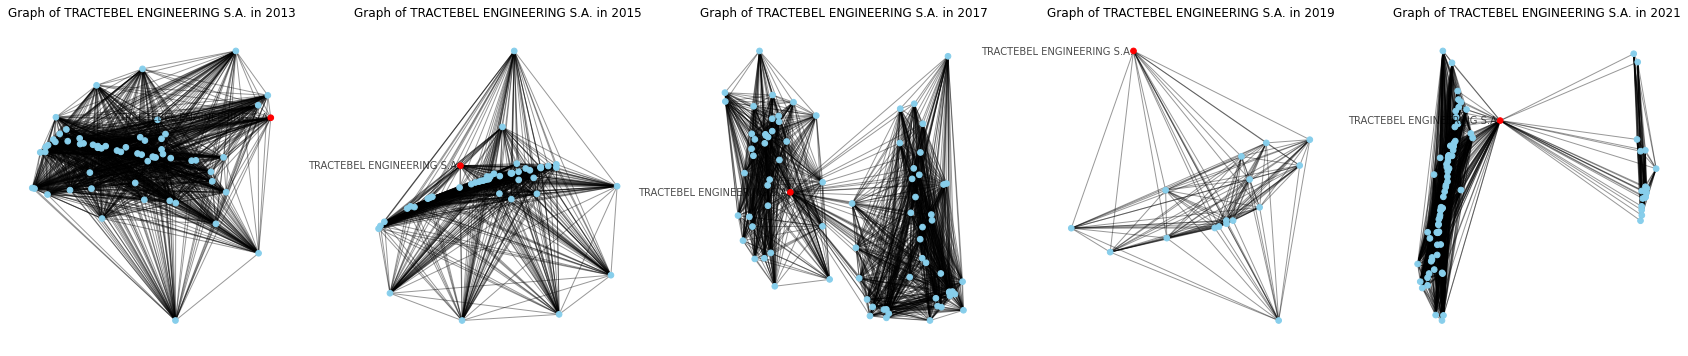

In [ ]:
# Doing the anlaysis by year (Unipartite)
node_list_Uni = ['TRACTEBEL ENGINEERING S.A.']
history = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,6))
ax = axes.flatten()

i = 0
for year in history:
  wb_data_filter = wb_data[wb_data['Fiscal Year']==year]
  # Grouping repeated transactions between country and suppliers
  wb_data_group = wb_data_filter.groupby(['Fiscal Year','Borrower Country','Supplier'])['Total Contract Amount (USD)'].sum()
  # wb_data_group = wb_data_filter.groupby(['Fiscal Year','Borrower Country','Supplier','Supplier Country'])['Total Contract Amount (USD)'].sum()
  wb_data_group = wb_data_group.reset_index()
  # Setting up the network 
  G = nx.Graph()
  G.add_nodes_from(wb_data_group['Borrower Country'], bipartite='Country') 
  G.add_nodes_from(wb_data_group['Supplier'], bipartite='Supplier') 
  G.add_weighted_edges_from(zip(wb_data_group['Borrower Country'], wb_data_group['Supplier'], wb_data_group['Total Contract Amount (USD)']), weight = 'contract_amt')
  G.to_undirected()
  # print(year)

  # Making projection network
  supplier_nodes = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 'Supplier'] 
  Supplier_graph = bipartite.generic_weighted_projected_graph(G, nodes=supplier_nodes, weight_function=my_weight)

  if len(set(Supplier_graph.nodes()).intersection(set(node_list_Uni)))>0:
    G_node_neighborhood = []
    
    for node in node_list_Uni:
      for n1 in Supplier_graph.neighbors(node):
        G_node_neighborhood.append(n1)        
        #for n2 in Supplier_graph.neighbors(n1):
          #G_node_neighborhood.append(n2)          
   
    closest_ngh_graph = Supplier_graph.subgraph(G_node_neighborhood + node_list_Uni)
 
    # Subgraph of selected node and its 1st and 2nd neighbors 
    # Specify colors
    cmap = mlt.colors.ListedColormap(['C0', 'darkorange'])
    Gcc = closest_ngh_graph.subgraph(sorted(nx.connected_components(closest_ngh_graph), key=len, reverse=True)[0])
    node_clr =[]
    labels = {}
    for node_name, attrb in Gcc.nodes(data=True):
      if node_name == node_list_Uni[0]:
        node_clr.append('red')
        labels[node_name] = node_name
      else:
        if attrb['bipartite'] =='Country':
          node_clr.append('darkorange')
          labels[node_name] = node_name 
        else:
          node_clr.append('skyblue')
  
    pos = nx.fruchterman_reingold_layout(Gcc)
    nx.draw_networkx_nodes(Gcc, pos, node_size=32, label=True, ax=ax[i], cmap=cmap, node_color = node_clr)
    nx.draw_networkx_edges(Gcc, pos, alpha=0.4, ax=ax[i])
    nx.draw_networkx_labels(Gcc,pos, labels, font_size=10, 
                            font_color='black', ax=ax[i], alpha =.7, 
                            horizontalalignment ='right', clip_on = False)
    ax[i].set_title(f"Graph of {node_list_Uni[0]} in {year}")
    ax[i].set_axis_off() 
    i +=1 

plt.show()

**Reference**: https://github.com/gloooryyt/oddball_py3